<a href="https://colab.research.google.com/github/TheKongers/celebA-headshot-GAN/blob/main/DCGanImageGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import time

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import sampler
# from helper_utils import set_all_seeds


In [ ]:
# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda:0


In [ ]:
# THIS IS ALL FOR REFERENCE

# def get_dataloaders_celeba(batch_size, num_workers=0,
#                            train_transforms=None,
#                            test_transforms=None,
#                            download=True):
#     """Targets are 40-dim vectors representing
#     00 - 5_o_Clock_Shadow
#     01 - Arched_Eyebrows
#     02 - Attractive
#     03 - Bags_Under_Eyes
#     04 - Bald
#     05 - Bangs
#     06 - Big_Lips
#     07 - Big_Nose
#     08 - Black_Hair
#     09 - Blond_Hair
#     10 - Blurry
#     11 - Brown_Hair
#     12 - Bushy_Eyebrows
#     13 - Chubby
#     14 - Double_Chin
#     15 - Eyeglasses
#     16 - Goatee
#     17 - Gray_Hair
#     18 - Heavy_Makeup
#     19 - High_Cheekbones
#     20 - Male
#     21 - Mouth_Slightly_Open
#     22 - Mustache
#     23 - Narrow_Eyes
#     24 - No_Beard
#     25 - Oval_Face
#     26 - Pale_Skin
#     27 - Pointy_Nose
#     28 - Receding_Hairline
#     29 - Rosy_Cheeks
#     30 - Sideburns
#     31 - Smiling
#     32 - Straight_Hair
#     33 - Wavy_Hair
#     34 - Wearing_Earrings
#     35 - Wearing_Hat
#     36 - Wearing_Lipstick
#     37 - Wearing_Necklace
#     38 - Wearing_Necktie
#     39 - Young
#     """

#     if train_transforms is None:
#         train_transforms = transforms.ToTensor()

#     if test_transforms is None:
#         test_transforms = transforms.ToTensor()

#     train_dataset = datasets.CelebA(root='data',
#                                     split='train',
#                                     transform=train_transforms,
#                                     download=download)

#     valid_dataset = datasets.CelebA(root='data',
#                                     split='valid',
#                                     transform=test_transforms)

#     test_dataset = datasets.CelebA(root='data',
#                                    split='test',
#                                    transform=test_transforms)


#     train_loader = DataLoader(dataset=train_dataset,
#                               batch_size=batch_size,
#                               num_workers=num_workers,
#                               shuffle=True)

#     valid_loader = DataLoader(dataset=test_dataset,
#                              batch_size=batch_size,
#                              num_workers=num_workers,
#                              shuffle=False)

#     test_loader = DataLoader(dataset=test_dataset,
#                              batch_size=batch_size,
#                              num_workers=num_workers,
#                              shuffle=False)

#     return train_loader, valid_loader, test_loader


In [ ]:
# unzip the file zipceleb.zip and input contents into new file called celebs
import zipfile
with zipfile.ZipFile("./drive/MyDrive/img_align_celeba.zip", 'r') as zip_ref:
    zip_ref.extractall("celebs")



In [ ]:
# # display the first image in the folder celebs
# import cv2
# import matplotlib.pyplot as plt

# image_path = 'celebs/000001.jpg'  # Replace with the actual path to your image
# image = cv2.imread(image_path)

# # Convert the image to RGB (if it's in BGR format)
# image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # Display the original image
# plt.imshow(image_rgb)
# plt.axis('off')
# plt.show()


In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os
import torchvision

IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64

custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((160, 160)),
    torchvision.transforms.Resize([IMAGE_HEIGHT, IMAGE_WIDTH]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = os.listdir(root)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.images[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, 1



custom_dataset = CustomDataset(root='celebs/img_align_celeba', transform=custom_transforms)

# print the size of dataset
print(len(custom_dataset))

202599


In [ ]:
# prompt: print out the maximum value of the entire matrix in the first entry of custom_dataset

print(min(custom_dataset[0][0].flatten()))


tensor(-0.9922)


In [ ]:
# prompt: split the dataset into three smaller datasets: train (80%), validation(10%), and test(10%)

# train_size = int(0.8 * len(custom_dataset))
# val_size = int(0.1 * len(custom_dataset))
# test_size = len(custom_dataset) - train_size - val_size

# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(custom_dataset, [train_size, val_size, test_size])

# print('train size:', len(train_dataset))
# print('validation size:', len(val_dataset))
# print('test size:', len(test_dataset))

# REMOVE THIS. ONLY NEED TEST


In [ ]:
num_workers = 4
batch_size = 128 # MAKE THIS 128 AFTER MOVING TO LARGER DATASET ################################################

train_loader = DataLoader(dataset=custom_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True)


In [ ]:

# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([128, 3, 64, 64])
Image label dimensions: torch.Size([128])


In [ ]:
class DCGAN(torch.nn.Module):

    def __init__(self, latent_dim=100,
                 num_feat_maps_gen=64, num_feat_maps_dis=64,
                 color_channels=3):
        super().__init__()


        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, num_feat_maps_gen*8,
                               kernel_size=4, stride=1, padding=0,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*8),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen*8 x 4 x 4
            #
            nn.ConvTranspose2d(num_feat_maps_gen*8, num_feat_maps_gen*4,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*4),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen*4 x 8 x 8
            #
            nn.ConvTranspose2d(num_feat_maps_gen*4, num_feat_maps_gen*2,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*2),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen*2 x 16 x 16
            #
            nn.ConvTranspose2d(num_feat_maps_gen*2, num_feat_maps_gen,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen x 32 x 32
            #
            nn.ConvTranspose2d(num_feat_maps_gen, color_channels,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            #
            # size: color_channels x 64 x 64
            #
            nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            #
            # input size color_channels x image_height x image_width
            #
            nn.Conv2d(color_channels, num_feat_maps_dis,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis x 32 x 32
            #
            nn.Conv2d(num_feat_maps_dis, num_feat_maps_dis*2,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*2),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis*2 x 16 x 16
            #
            nn.Conv2d(num_feat_maps_dis*2, num_feat_maps_dis*4,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*4),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis*4 x 8 x 8
            #
            nn.Conv2d(num_feat_maps_dis*4, num_feat_maps_dis*8,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*8),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis*8 x 4 x 4
            #
            nn.Conv2d(num_feat_maps_dis*8, 1,
                      kernel_size=4, stride=1, padding=0),

            # size: 1 x 1 x 1
            nn.Flatten(),

        )


    def generator_forward(self, z):
        img = self.generator(z)
        return img

    def discriminator_forward(self, img):
        logits = model.discriminator(img)
        return logits

In [ ]:
# set_all_seeds(RANDOM_SEED)


model = DCGAN()
model.to(DEVICE)

GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002


optim_gen = torch.optim.Adam(model.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=GENERATOR_LEARNING_RATE)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

In [ ]:
def train_gan_v1(num_epochs, model, optimizer_gen, optimizer_discr,
                 latent_dim, device, train_loader, loss_fn=None,
                 logging_interval=100,
                 save_model=None):

    log_dict = {'train_generator_loss_per_batch': [],
                'train_discriminator_loss_per_batch': [],
                'train_discriminator_real_acc_per_batch': [],
                'train_discriminator_fake_acc_per_batch': [],
                'images_from_noise_per_epoch': []}

    if loss_fn is None:
        loss_fn = F.binary_cross_entropy_with_logits

    # Batch of latent (noise) vectors for
    # evaluating / visualizing the training progress
    # of the generator
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device) # format NCHW

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            batch_size = features.size(0)

            # real images
            real_images = features.to(device)
            real_labels = torch.ones(batch_size, device=device) # real label = 1

            # generated (fake) images
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)  # format NCHW
            fake_images = model.generator_forward(noise)
            fake_labels = torch.zeros(batch_size, device=device) # fake label = 0
            flipped_fake_labels = real_labels # here, fake label = 1

            # --------------------------
            # Train Discriminator
            # --------------------------

            optimizer_discr.zero_grad()

            # get discriminator loss on real images
            discr_pred_real = model.discriminator_forward(real_images).view(-1) # Nx1 -> N
            real_loss = loss_fn(discr_pred_real, real_labels)
            # real_loss.backward()

            # get discriminator loss on fake images
            discr_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
            fake_loss = loss_fn(discr_pred_fake, fake_labels)
            # fake_loss.backward()

            # combined loss
            discr_loss = 0.5*(real_loss + fake_loss)
            discr_loss.backward()

            optimizer_discr.step()

            # --------------------------
            # Train Generator
            # --------------------------

            optimizer_gen.zero_grad()

            # get discriminator loss on fake images with flipped labels
            discr_pred_fake = model.discriminator_forward(fake_images).view(-1)
            gener_loss = loss_fn(discr_pred_fake, flipped_fake_labels)
            gener_loss.backward()

            optimizer_gen.step()

            # --------------------------
            # Logging
            # --------------------------
            log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
            log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())

            predicted_labels_real = torch.where(discr_pred_real.detach() > 0., 1., 0.)
            predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., 1., 0.)
            acc_real = (predicted_labels_real == real_labels).float().mean()*100.
            acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
            log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
            log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())

            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f'
                       % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), gener_loss.item(), discr_loss.item()))

        ### Save images for evaluation
        with torch.no_grad():
            fake_images = model.generator_forward(fixed_noise).detach().cpu()
            log_dict['images_from_noise_per_epoch'].append(
                torchvision.utils.make_grid(fake_images, padding=2, normalize=True))


        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    if save_model is not None:
        torch.save(model.state_dict(), save_model)

    return log_dict

In [ ]:
NUM_EPOCHS = 20

log_dict = train_gan_v1(num_epochs=NUM_EPOCHS, model=model,
                        optimizer_gen=optim_gen,
                        optimizer_discr=optim_discr,
                        latent_dim=100,
                        device=DEVICE,
                        train_loader=train_loader,
                        logging_interval=100,
                        save_model='gan_celeba_01.pt')

Epoch: 001/020 | Batch 000/1583 | Gen/Dis Loss: 2.9518/0.1555
Epoch: 001/020 | Batch 100/1583 | Gen/Dis Loss: 3.1382/0.2803
Epoch: 001/020 | Batch 200/1583 | Gen/Dis Loss: 0.3437/0.2505
Epoch: 001/020 | Batch 300/1583 | Gen/Dis Loss: 4.2340/0.1544
Epoch: 001/020 | Batch 400/1583 | Gen/Dis Loss: 3.7598/0.0907
Epoch: 001/020 | Batch 500/1583 | Gen/Dis Loss: 2.8815/0.2433
Epoch: 001/020 | Batch 600/1583 | Gen/Dis Loss: 3.0822/0.0975
Epoch: 001/020 | Batch 700/1583 | Gen/Dis Loss: 3.4207/0.3336
Epoch: 001/020 | Batch 800/1583 | Gen/Dis Loss: 1.5722/0.2597
Epoch: 001/020 | Batch 900/1583 | Gen/Dis Loss: 3.1274/0.0752
Epoch: 001/020 | Batch 1000/1583 | Gen/Dis Loss: 4.3271/0.1358
Epoch: 001/020 | Batch 1100/1583 | Gen/Dis Loss: 3.3948/0.2456
Epoch: 001/020 | Batch 1200/1583 | Gen/Dis Loss: 3.1226/0.0954
Epoch: 001/020 | Batch 1300/1583 | Gen/Dis Loss: 3.5839/0.0691
Epoch: 001/020 | Batch 1400/1583 | Gen/Dis Loss: 3.0394/0.0672
Epoch: 001/020 | Batch 1500/1583 | Gen/Dis Loss: 1.7329/0.4204
Ti

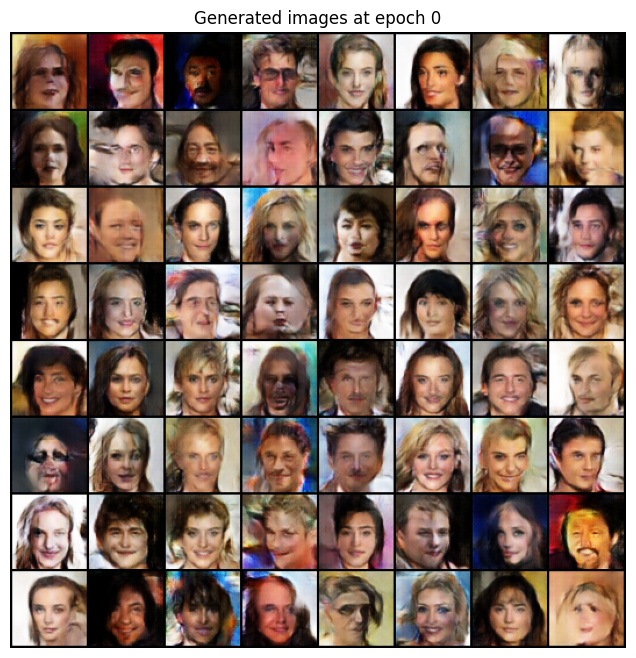

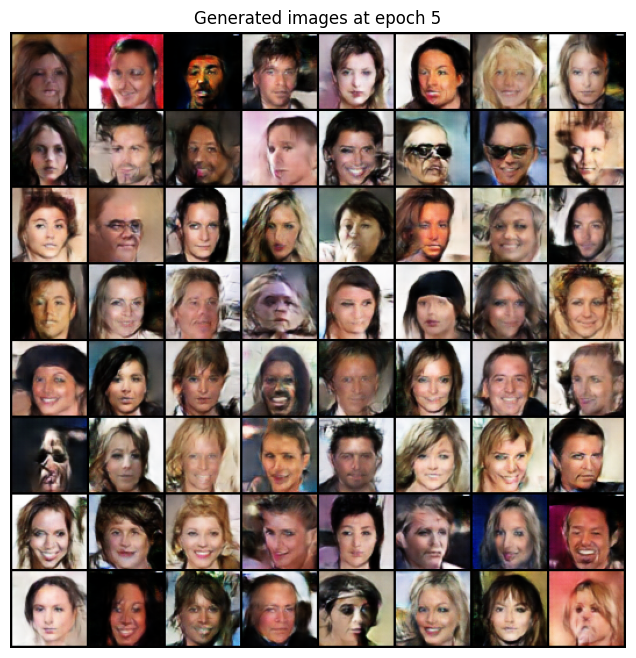

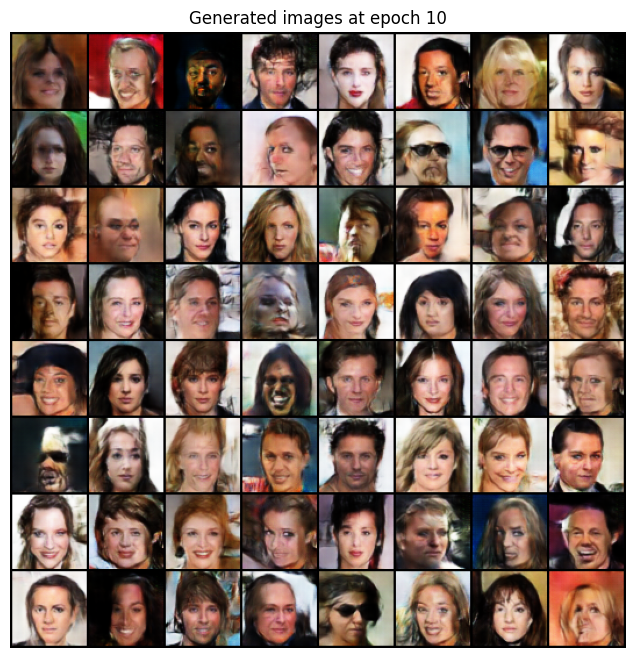

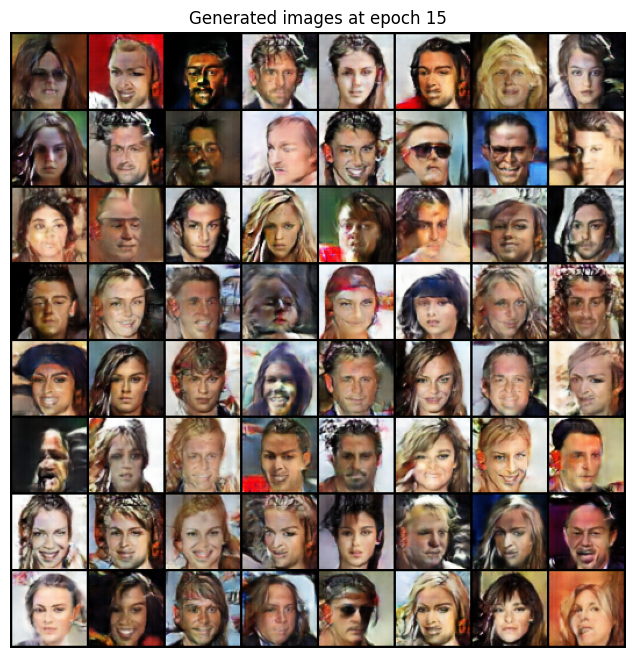

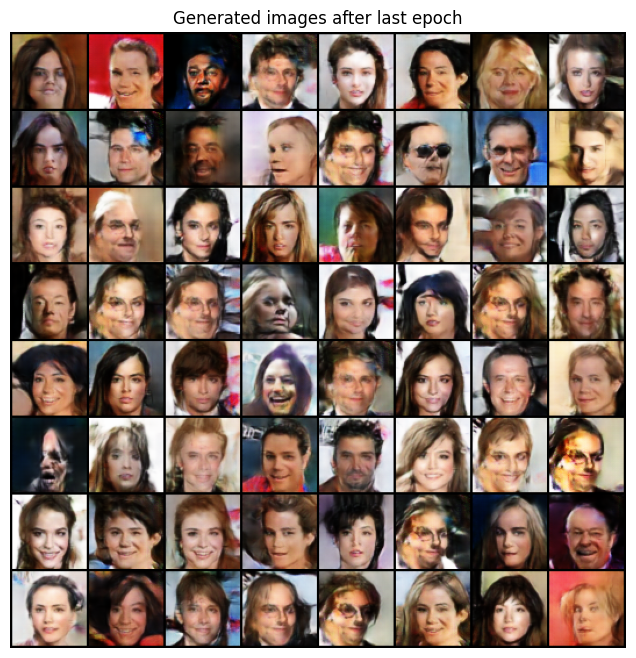

In [ ]:
for i in range(0, NUM_EPOCHS, 5):

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()


plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()